In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.UCF101(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(texts_list):
    with torch.no_grad():
        label_ids = []
        text_features_cuda = []
        cls_features_cuda = []
        for label_id, texts in texts_list.items():
            label_ids.append([label_id] * len(texts))
            class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            text_features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        text_features = torch.vstack(text_features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, text_features, text_features_cuda, cls_features_cuda, masked_similarity

In [10]:
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create template text features
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(template_label_texts_list)

In [11]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/ucf_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [12]:
# Mapping between CuPL and cls_name
special_class_mapping = {
    'Hand Stand Pushups': 'Handstand_Pushups'
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
    'Archery': ['arrow'],
    'Baby Crawling': ['baby'],
    'Baseball Pitch': ['ball'],
    'Basketball': ['ball'],
    'Basketball Dunk': ['ball'],
    'Billiards': ['ball'],
    'Blowing Candles': ['candle'],
    'Bowling': ['ball'],
    'Cricket Bowling': ['ball'],
    'Cricket Shot': ['ball'],
    'Cutting In Kitchen': ['cut'],
    'Diving': ['dive', 'water'],
    'Drumming': ['drum'],
    'Fencing': ['fencer', 'swordsmanship', 'stick'],
    'Front Crawl': ['swimming'],
    'Haircut': ['hair'],
    'Hammer Throw': ['ball'],
    'Hammering': ['hammer'],
    'Hand Stand Pushups': ['handstand', 'hand'],
    'Horse Riding': ['horseback'],
    'Jumping Jack': ['arm'],
    'Knitting': ['needle'],
    'Lunges': ['lunge', 'lunging'],
    'Mixing': ['mix'],
    'Nunchucks': ['stick'],
    'Pull Ups': ['bar'],
    'Punch': ['punching'],
    'Shaving Beard': ['razor'],
    'Shotput': ['shot'],
    'Skate Boarding': ['skateboard'],
    'Skiing': ['ski'],
    'Skijet': ['jet'],
    'Sky Diving': ['skydive', 'parachute'],
    'Surfing': ['surfboard', 'board'],
    'Typing': ['keyboard'],
    'Uneven Bars': ['bar'],
    'Volleyball Spiking': ['ball'],
}

In [13]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 6 prompts for (0)Apply_Eye_Makeup
["There is no one definitive answer to this question, as people's individual circumstances and preferences will differ.", 'There is no one answer to this question, as everyone has their own unique style.', '1.', '1.', '1.', '1) Place a small amount of foundation on the tip of your finger.']

Filtered 6 prompts for (1)Apply_Lipstick
['There is no one definitive answer to this question.', 'There is no one definitive answer to this question.', '1.', '1.', 'Start with freshly exfoliated and moisturized lips.', 'Start by putting the lip balm on your lips to moisturize them and make them softer.']

Filtered 1 prompts for (3)Baby_Crawling
['Moving about on all fours with the belly off the ground.']

Filtered 2 prompts for (5)Band_Marching
['.', 'Some people might look like they are having a lot of fun, while others may look like they are struggling.']

Filtered 3 prompts for (6)Baseball_Pitch
['When the pitcher winds up, he brings his arm back behind

In [14]:
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create original gpt3 text features
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(filtered_gpt3_label_texts_list)

In [15]:
from collections import defaultdict

imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)

In [16]:
# Create image features
with torch.no_grad():
    img_label_ids = []
    img_features_cuda = []
    img_cls_features_cuda = []
    img_cls_name_similarity_cuda = []
    img_template_cls_similarity_cuda = []
    img_template_text_similarity_cuda = []
    img_original_gpt3_cls_similarity_cuda = []
    img_original_gpt3_text_similarity_cuda = []
    img_filtered_gpt3_cls_similarity_cuda = []
    img_filtered_gpt3_text_similarity_cuda = []
    for label_id, imgs in tqdm(imgs_grouped.items()):
        img_label_ids.append([label_id] * len(imgs))
        imgs = torch.stack([preprocess(img) for img in imgs]).to(device)
        img_embeddings = model.encode_image(imgs)
        img_embeddings /= img_embeddings.norm(dim=-1, keepdim=True)
        img_embedding = img_embeddings.mean(dim=0)
        img_embedding /= img_embedding.norm()
        img_features_cuda.append(img_embeddings)
        img_cls_features_cuda.append(img_embedding)
        # mean by cls then mul
        img_cls_name_similarity_cuda.append((img_embeddings @ cls_name_features_cuda.T).mean(dim=0))
        img_template_cls_similarity_cuda.append((img_embeddings @ template_cls_features_cuda.T).mean(dim=0))
        img_original_gpt3_cls_similarity_cuda.append((img_embeddings @ original_gpt3_cls_features_cuda.T).mean(dim=0))
        img_filtered_gpt3_cls_similarity_cuda.append((img_embeddings @ filtered_gpt3_cls_features_cuda.T).mean(dim=0))
        # mul then mean by cls
        img_template_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in template_text_features_cuda]))
        img_original_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in original_gpt3_text_features_cuda]))
        img_filtered_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in filtered_gpt3_text_features_cuda]))
    img_label_ids = np.hstack(img_label_ids)
    img_features_cuda = torch.vstack(img_features_cuda)
    img_features = img_features_cuda.cpu().numpy()
    img_cls_features_cuda = torch.vstack(img_cls_features_cuda)
    # mean by cls then mul
    img_cls_name_similarity = torch.vstack(img_cls_name_similarity_cuda).cpu().numpy()
    img_template_cls_similarity = torch.vstack(img_template_cls_similarity_cuda).cpu().numpy()
    img_original_gpt3_cls_similarity = torch.vstack(img_original_gpt3_cls_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_cls_similarity = torch.vstack(img_filtered_gpt3_cls_similarity_cuda).cpu().numpy()
    # mul then mean by cls
    img_template_text_similarity = torch.vstack(img_template_text_similarity_cuda).cpu().numpy()
    img_original_gpt3_text_similarity = torch.vstack(img_original_gpt3_text_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_text_similarity = torch.vstack(img_filtered_gpt3_text_similarity_cuda).cpu().numpy()

    # Fill diagonal for better visibility
    img_masked_similarity = (img_cls_features_cuda @ img_cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

100%|██████████| 101/101 [00:17<00:00,  5.90it/s]


In [17]:
# Zero-shot classification using CLIP
with torch.no_grad():
    logits_cls_name_cuda = img_features_cuda @ cls_name_features_cuda.T
    logits_template_cls_cuda = img_features_cuda @ template_cls_features_cuda.T
    logits_original_gpt3_cls_cuda = img_features_cuda @ original_gpt3_cls_features_cuda.T
    logits_filtered_gpt3_cls_cuda = img_features_cuda @ filtered_gpt3_cls_features_cuda.T

    pred_cls_name = logits_cls_name_cuda.argmax(dim=-1).cpu().numpy()
    pred_template_cls = logits_template_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_original_gpt3_cls = logits_original_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_filtered_gpt3_cls = logits_filtered_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()

    correct_cls_name = (pred_cls_name == img_label_ids).mean()
    correct_template_cls = (pred_template_cls == img_label_ids).mean()
    correct_original_gpt3 = (pred_original_gpt3_cls == img_label_ids).mean()
    correct_filtered_gpt3 = (pred_filtered_gpt3_cls == img_label_ids).mean()

In [18]:
print(f'Accuracy of CLIP with class names: {correct_cls_name*100:.2f}%')
print(f'Accuracy of CLIP with text template: {correct_template_cls*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text: {correct_original_gpt3*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text: {correct_filtered_gpt3*100:.2f}%')

Accuracy of CLIP with class names: 60.96%
Accuracy of CLIP with text template: 64.87%
Accuracy of CLIP with original GPT-3 text: 70.55%
Accuracy of CLIP with filtered GPT-3 text: 70.74%


In [19]:
def print_top_similarity(similarity, top=10):
    # Get the indices of top similarity values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top similarities
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, Similarity: {similarity[label1, label2]}')

In [20]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [21]:
def visualize_auto_similarity(masked_similarity, title):
    print(f'{title.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_similarity(np.triu(masked_similarity, k=1))
    plot_similarity(masked_similarity, title)

In [22]:
def visualize_cross_similarity(similarity, title, xlabel='Text', ylabel='Image'):
    print(f'{title.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_similarity(similarity, top=20)
    plot_similarity(similarity, title, xlabel=xlabel, ylabel=ylabel)

Class name similarity mean: 0.72705078125
Class name similarity std: 0.052642822265625
Rank 1: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.94970703125
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.9306640625
Rank 3: (45)Juggling_Balls - (83)Soccer_Juggling, Similarity: 0.9296875
Rank 4: (39)High_Jump - (50)Long_Jump, Similarity: 0.92822265625
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.92041015625
Rank 6: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.916015625
Rank 7: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.91259765625
Rank 8: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.9072265625
Rank 9: (0)Apply_Eye_Makeup - (1)Apply_Lipstick, Similarity: 0.90673828125
Rank 10: (15)Bowling - (22)Cricket_Bowling, Similarity: 0.90283203125


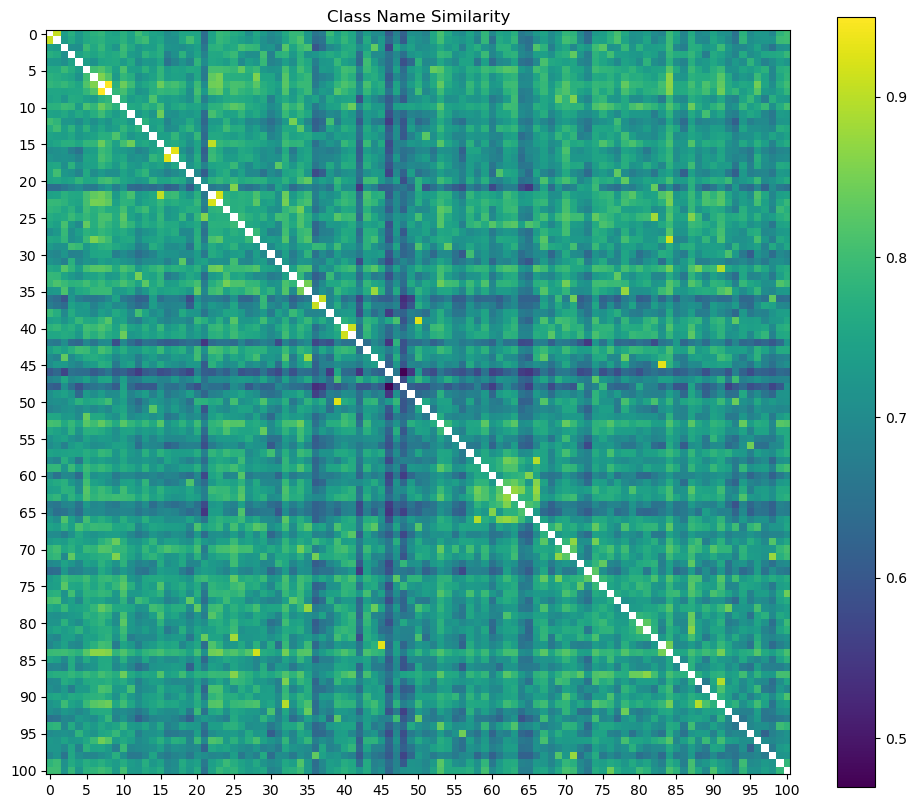

Text template similarity mean: 0.71337890625
Text template similarity std: 0.05523681640625
Rank 1: (39)High_Jump - (50)Long_Jump, Similarity: 0.95068359375
Rank 2: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.9501953125
Rank 3: (15)Bowling - (22)Cricket_Bowling, Similarity: 0.93408203125
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.9267578125
Rank 5: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.92431640625
Rank 6: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.92431640625
Rank 7: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.92138671875
Rank 8: (45)Juggling_Balls - (83)Soccer_Juggling, Similarity: 0.91552734375
Rank 9: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.90625
Rank 10: (58)Playing_Cello - (66)Playing_Violin, Similarity: 0.89892578125


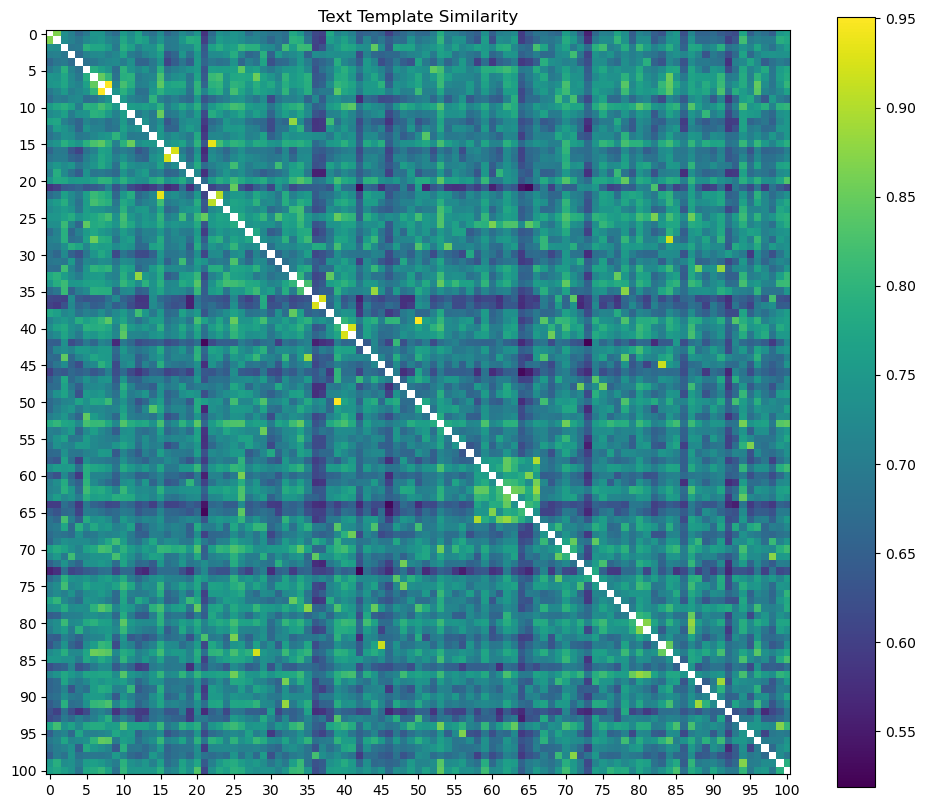

Original gpt-3 text similarity mean: 0.744140625
Original gpt-3 text similarity std: 0.056549072265625
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, Similarity: 0.96142578125
Rank 2: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.95361328125
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.951171875
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.9501953125
Rank 5: (39)High_Jump - (50)Long_Jump, Similarity: 0.9443359375
Rank 6: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.9404296875
Rank 7: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, Similarity: 0.931640625
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.93017578125
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, Similarity: 0.9208984375


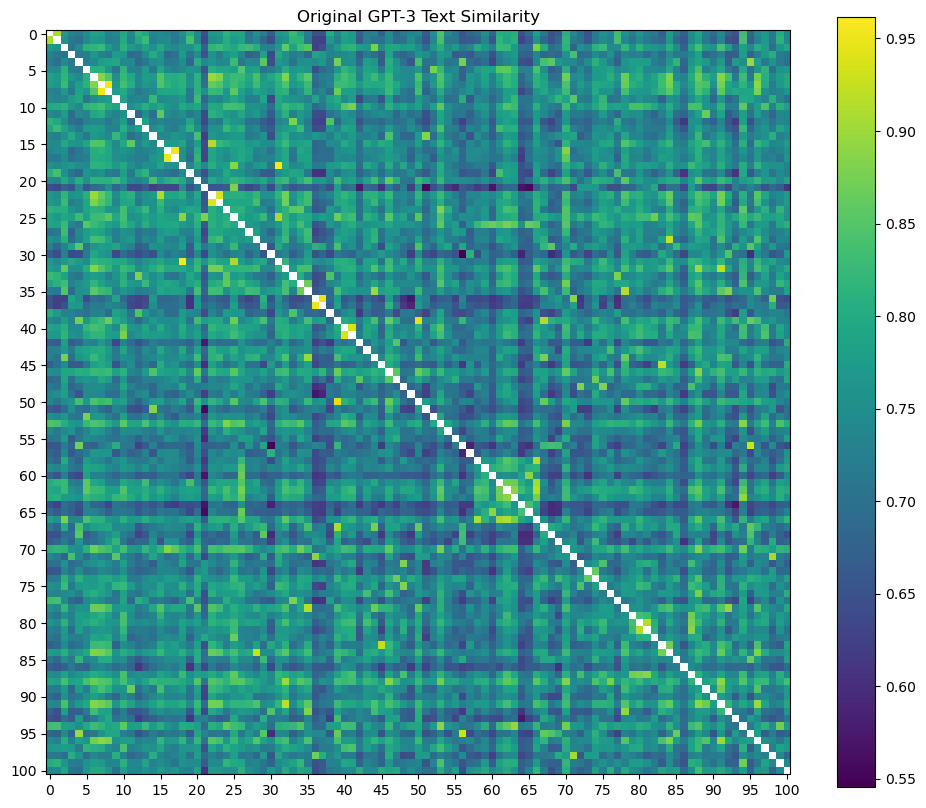

Filtered gpt-3 text similarity mean: 0.73681640625
Filtered gpt-3 text similarity std: 0.05755615234375
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, Similarity: 0.95947265625
Rank 2: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.95361328125
Rank 3: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.94970703125
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.94970703125
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.9404296875
Rank 6: (39)High_Jump - (50)Long_Jump, Similarity: 0.939453125
Rank 7: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, Similarity: 0.93017578125
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.92431640625
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, Similarity: 0.919921875


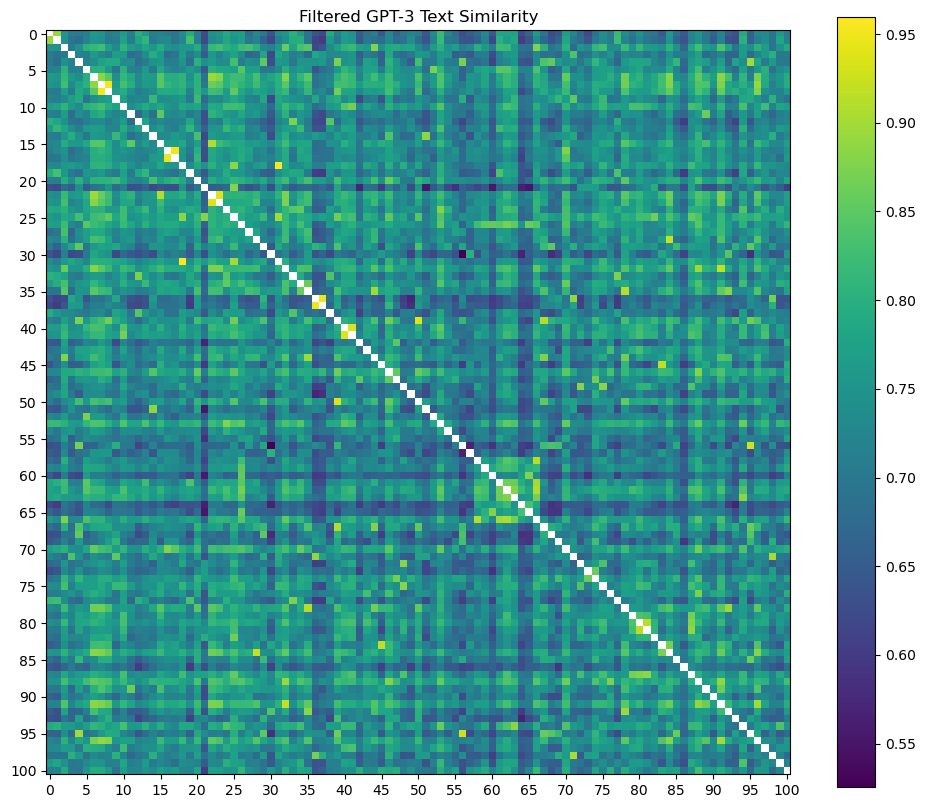

In [23]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name Similarity')
visualize_auto_similarity(template_masked_similarity, 'Text Template Similarity')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text Similarity')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text Similarity')

Image similarity mean: 0.7294921875
Image similarity std: 0.0853271484375
Rank 1: (18)Breast_Stroke - (31)Front_Crawl, Similarity: 0.97314453125
Rank 2: (39)High_Jump - (44)Javelin_Throw, Similarity: 0.9697265625
Rank 3: (4)Balance_Beam - (56)Parallel_Bars, Similarity: 0.962890625
Rank 4: (4)Balance_Beam - (29)Floor_Gymnastics, Similarity: 0.96240234375
Rank 5: (88)Swing - (93)Trampoline_Jumping, Similarity: 0.96044921875
Rank 6: (39)High_Jump - (50)Long_Jump, Similarity: 0.958984375
Rank 7: (18)Breast_Stroke - (25)Diving, Similarity: 0.95751953125
Rank 8: (78)Shotput - (92)Throw_Discus, Similarity: 0.95703125
Rank 9: (12)Blow_Dry_Hair - (33)Haircut, Similarity: 0.953125
Rank 10: (44)Javelin_Throw - (50)Long_Jump, Similarity: 0.951171875


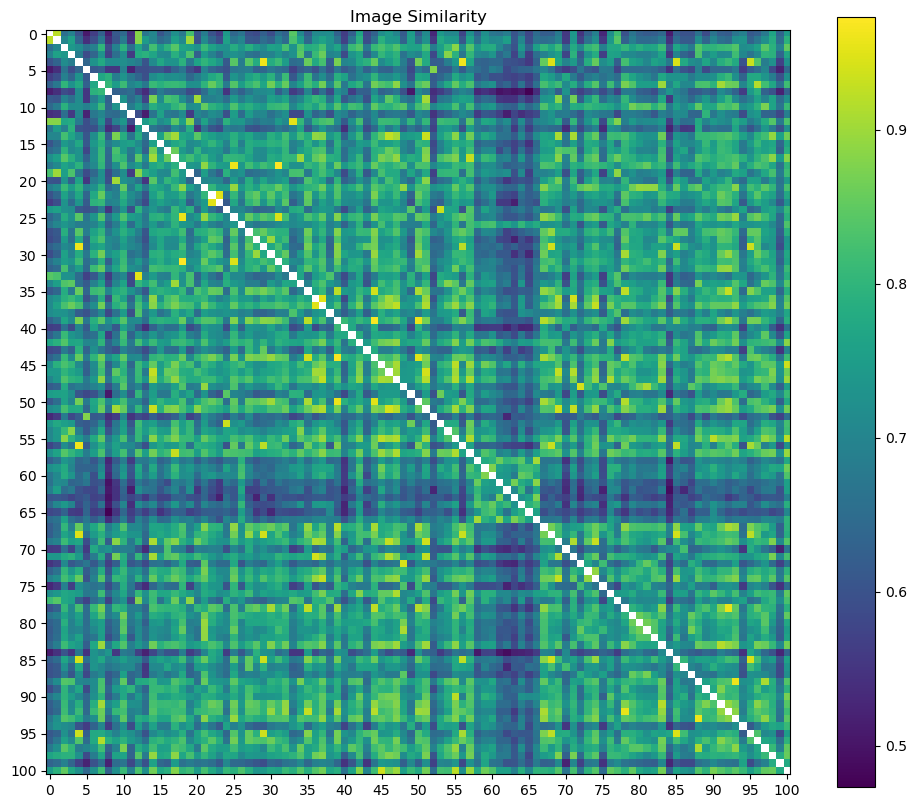

Image to class name similarity mean: 0.208984375
Image to class name similarity std: 0.030303955078125
Image to class name similarity diagonal mean: 0.2939453125
Image to class name similarity diagonal std: 0.0274810791015625
Image to class name similarity non-diagonal mean: 0.2081298828125
Image to class name similarity non-diagonal std: 0.0290985107421875
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.412109375
Rank 1: (65)Playing_Tabla - (65)Playing_Tabla, Similarity: 0.338134765625
Rank 2: (89)Table_Tennis_Shot - (89)Table_Tennis_Shot, Similarity: 0.337890625
Rank 3: (64)Playing_Sitar - (64)Playing_Sitar, Similarity: 0.337158203125
Rank 4: (60)Playing_Dhol - (60)Playing_Dhol, Similarity: 0.337158203125
Rank 5: (36)Handstand_Pushups - (36)Handstand_Pushups, Similarity: 0.3349609375
Rank 6: (73)Rock_Climbing_Indoor - (73)Rock_Climbing_Indoor, Similarity: 0.333984375
Rank 7: (82)Sky_Diving - (82)Sky_Diving, Similarity: 0.333740234375
Rank 8: (93)Trampoline_

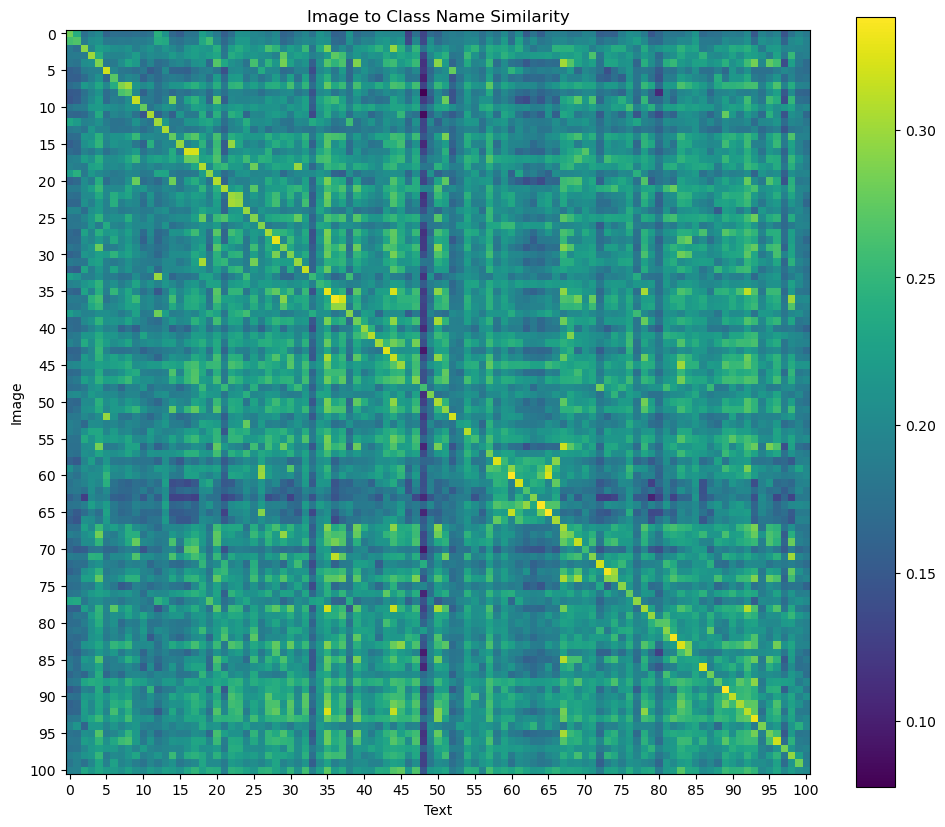

Image to text template similarity mean: 0.2000732421875
Image to text template similarity std: 0.031585693359375
Image to text template similarity diagonal mean: 0.294921875
Image to text template similarity diagonal std: 0.02569580078125
Image to text template similarity non-diagonal mean: 0.1990966796875
Image to text template similarity non-diagonal std: 0.0301666259765625
Image to text template similarity diagonal mean to non-diagonal mean ratio: 1.4814453125
Rank 1: (65)Playing_Tabla - (65)Playing_Tabla, Similarity: 0.3447265625
Rank 2: (64)Playing_Sitar - (64)Playing_Sitar, Similarity: 0.34326171875
Rank 3: (60)Playing_Dhol - (60)Playing_Dhol, Similarity: 0.33935546875
Rank 4: (73)Rock_Climbing_Indoor - (73)Rock_Climbing_Indoor, Similarity: 0.338623046875
Rank 5: (86)Sumo_Wrestling - (86)Sumo_Wrestling, Similarity: 0.33837890625
Rank 6: (36)Handstand_Pushups - (36)Handstand_Pushups, Similarity: 0.337890625
Rank 7: (89)Table_Tennis_Shot - (89)Table_Tennis_Shot, Similarity: 0.33666

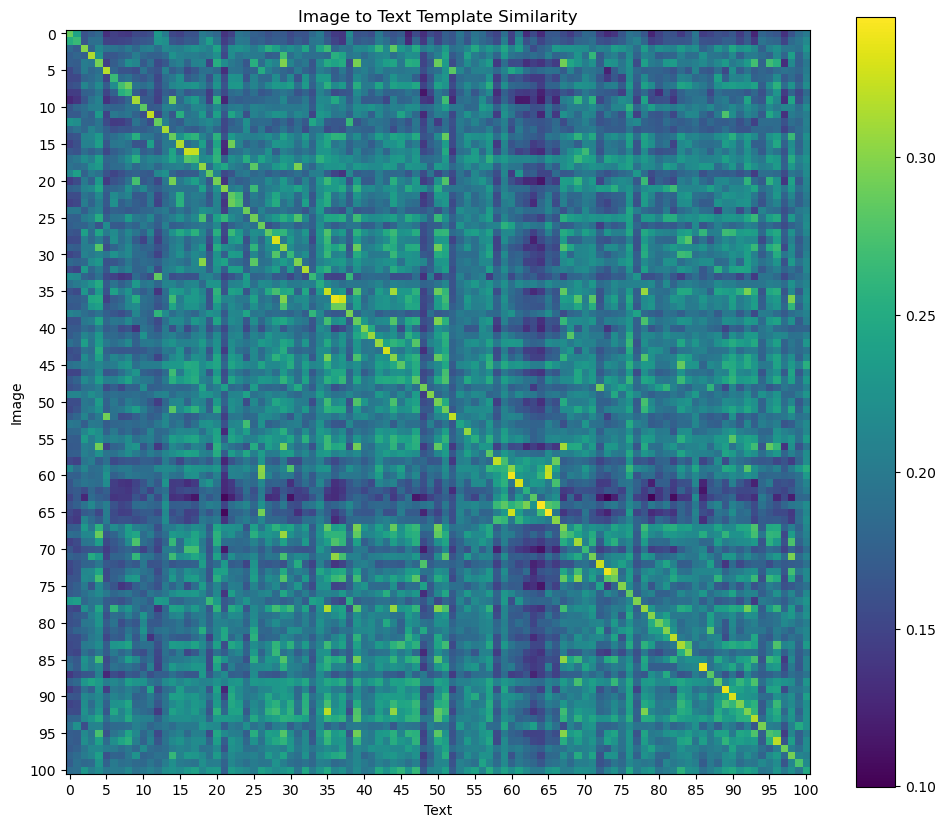

Image to text template similarity (individual) mean: 0.1843232363462448
Image to text template similarity (individual) std: 0.029197297990322113
Image to text template similarity (individual) diagonal mean: 0.27166566252708435
Image to text template similarity (individual) diagonal std: 0.02410566620528698
Image to text template similarity (individual) non-diagonal mean: 0.18344980478286743
Image to text template similarity (individual) non-diagonal std: 0.02789527364075184
Image to text template similarity (individual) diagonal mean to non-diagonal mean ratio: 1.4808719158172607
Rank 1: (65)Playing_Tabla - (65)Playing_Tabla, Similarity: 0.318359375
Rank 2: (64)Playing_Sitar - (64)Playing_Sitar, Similarity: 0.317138671875
Rank 3: (36)Handstand_Pushups - (36)Handstand_Pushups, Similarity: 0.31494140625
Rank 4: (89)Table_Tennis_Shot - (89)Table_Tennis_Shot, Similarity: 0.3134765625
Rank 5: (73)Rock_Climbing_Indoor - (73)Rock_Climbing_Indoor, Similarity: 0.3134765625
Rank 6: (60)Playing_D

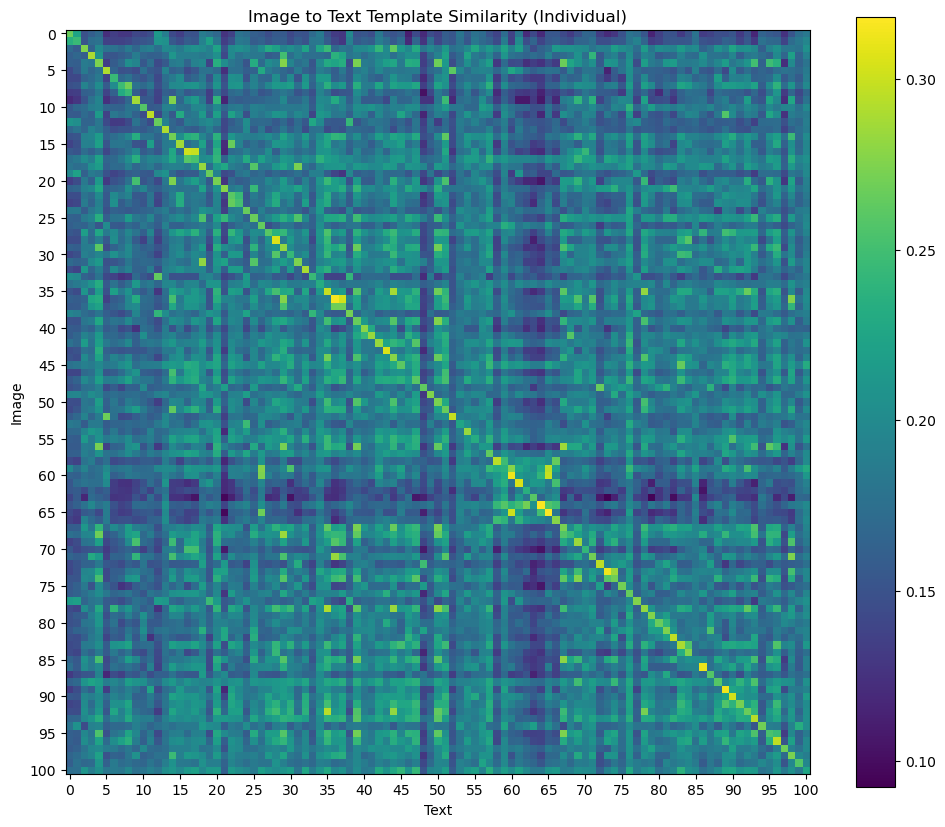

Image to original gpt-3 text similarity mean: 0.2032470703125
Image to original gpt-3 text similarity std: 0.032501220703125
Image to original gpt-3 text similarity diagonal mean: 0.30517578125
Image to original gpt-3 text similarity diagonal std: 0.0189971923828125
Image to original gpt-3 text similarity non-diagonal mean: 0.2021484375
Image to original gpt-3 text similarity non-diagonal std: 0.0309295654296875
Image to original gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.509765625
Rank 1: (86)Sumo_Wrestling - (86)Sumo_Wrestling, Similarity: 0.35009765625
Rank 2: (65)Playing_Tabla - (65)Playing_Tabla, Similarity: 0.34765625
Rank 3: (36)Handstand_Pushups - (36)Handstand_Pushups, Similarity: 0.3447265625
Rank 4: (89)Table_Tennis_Shot - (89)Table_Tennis_Shot, Similarity: 0.3408203125
Rank 5: (11)Billiards - (11)Billiards, Similarity: 0.33740234375
Rank 6: (15)Bowling - (15)Bowling, Similarity: 0.337158203125
Rank 7: (73)Rock_Climbing_Indoor - (73)Rock_Climbing_Indoo

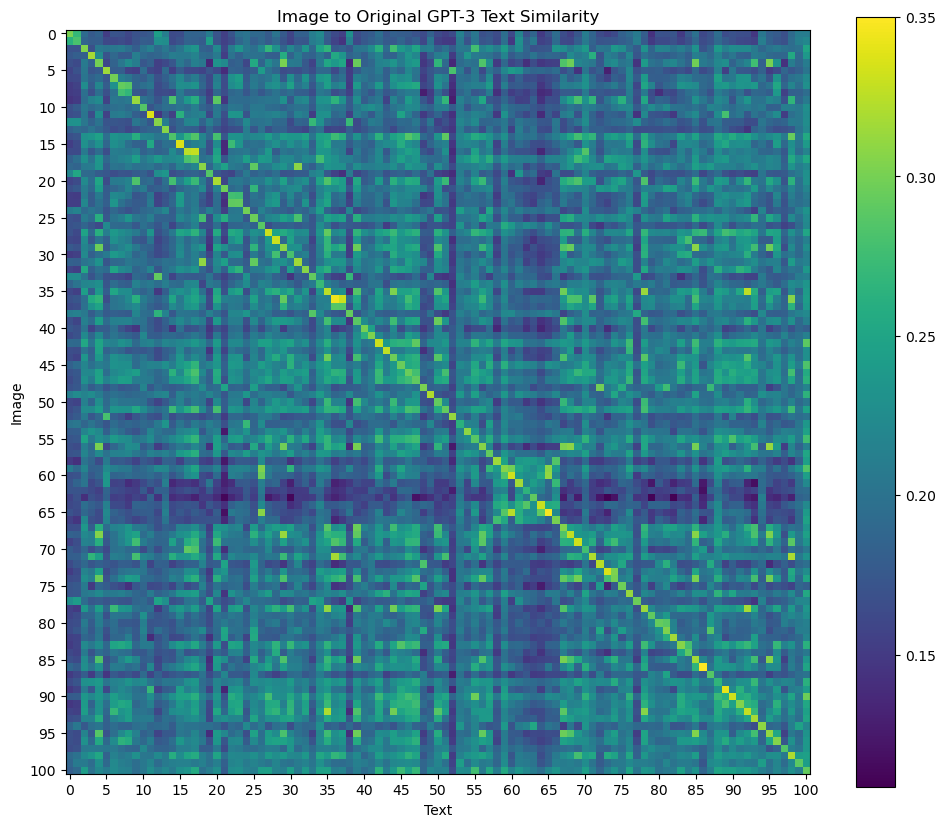

Image to original gpt-3 text similarity (individual) mean: 0.1909959316253662
Image to original gpt-3 text similarity (individual) std: 0.030202943831682205
Image to original gpt-3 text similarity (individual) diagonal mean: 0.2868615984916687
Image to original gpt-3 text similarity (individual) diagonal std: 0.01875114068388939
Image to original gpt-3 text similarity (individual) non-diagonal mean: 0.19003728032112122
Image to original gpt-3 text similarity (individual) non-diagonal std: 0.028722859919071198
Image to original gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.5095016956329346
Rank 1: (86)Sumo_Wrestling - (86)Sumo_Wrestling, Similarity: 0.327392578125
Rank 2: (65)Playing_Tabla - (65)Playing_Tabla, Similarity: 0.32666015625
Rank 3: (36)Handstand_Pushups - (36)Handstand_Pushups, Similarity: 0.325439453125
Rank 4: (89)Table_Tennis_Shot - (89)Table_Tennis_Shot, Similarity: 0.32373046875
Rank 5: (90)Tai_Chi - (90)Tai_Chi, Similarity: 0.3198242187

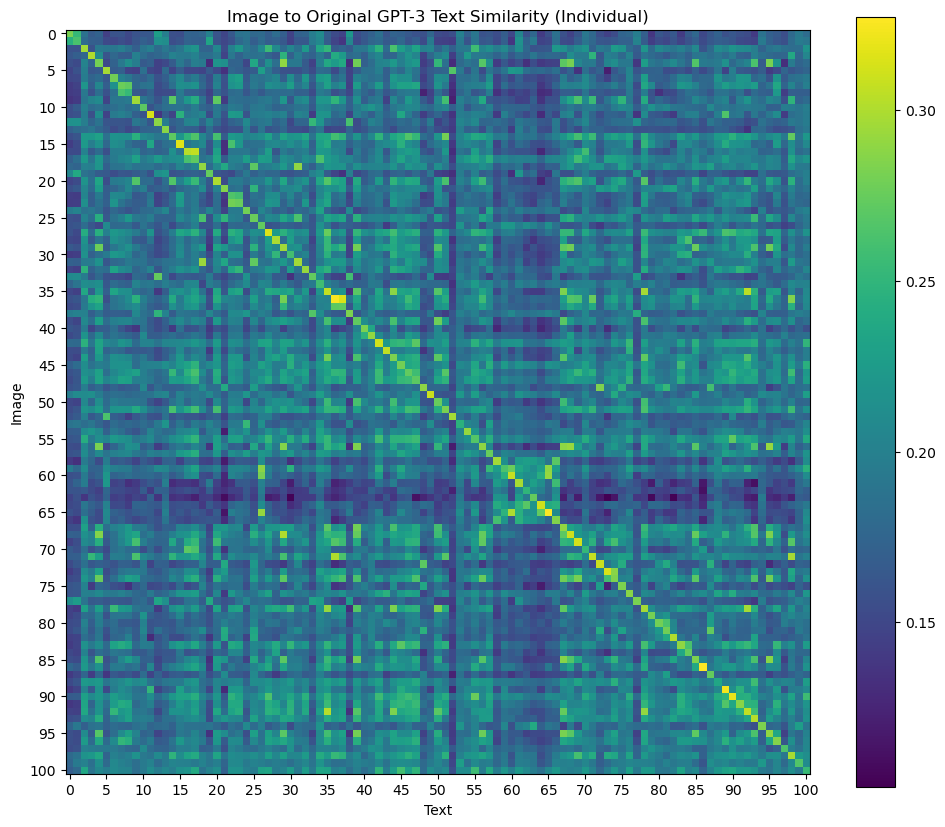

Image to filtered gpt-3 text similarity mean: 0.2021484375
Image to filtered gpt-3 text similarity std: 0.032867431640625
Image to filtered gpt-3 text similarity diagonal mean: 0.305419921875
Image to filtered gpt-3 text similarity diagonal std: 0.018951416015625
Image to filtered gpt-3 text similarity non-diagonal mean: 0.2010498046875
Image to filtered gpt-3 text similarity non-diagonal std: 0.031280517578125
Image to filtered gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.51953125
Rank 1: (65)Playing_Tabla - (65)Playing_Tabla, Similarity: 0.34912109375
Rank 2: (86)Sumo_Wrestling - (86)Sumo_Wrestling, Similarity: 0.34814453125
Rank 3: (36)Handstand_Pushups - (36)Handstand_Pushups, Similarity: 0.3447265625
Rank 4: (89)Table_Tennis_Shot - (89)Table_Tennis_Shot, Similarity: 0.340087890625
Rank 5: (11)Billiards - (11)Billiards, Similarity: 0.338134765625
Rank 6: (15)Bowling - (15)Bowling, Similarity: 0.3369140625
Rank 7: (73)Rock_Climbing_Indoor - (73)Rock_Climbing_Ind

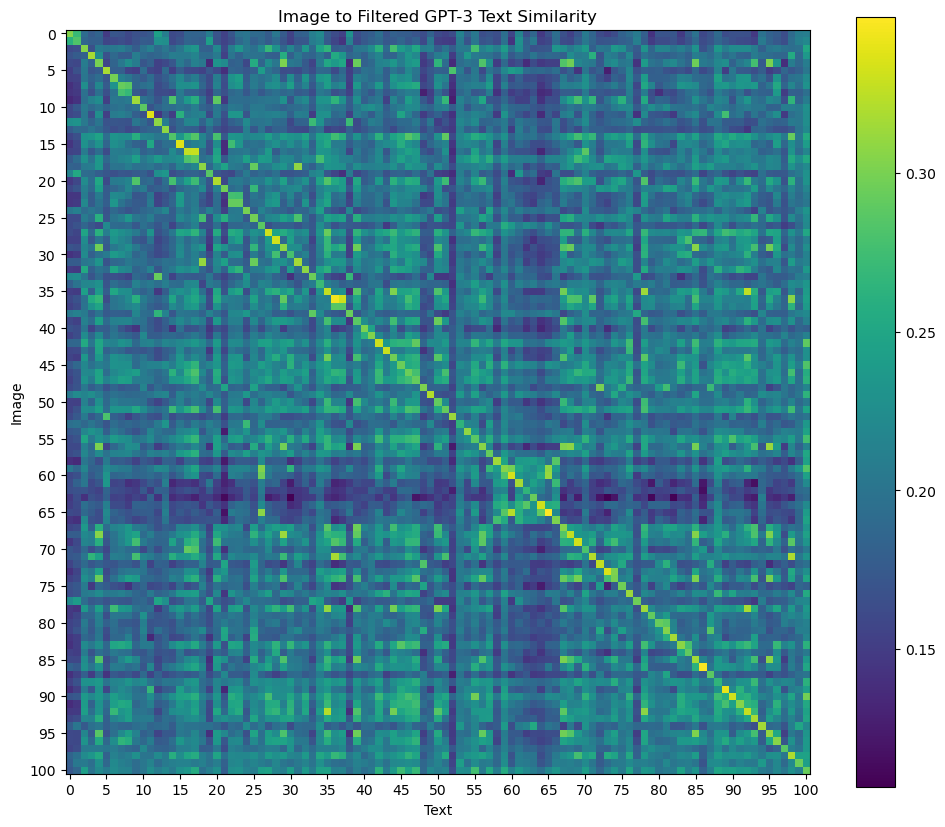

Image to filtered gpt-3 text similarity (individual) mean: 0.19091051816940308
Image to filtered gpt-3 text similarity (individual) std: 0.03062259964644909
Image to filtered gpt-3 text similarity (individual) diagonal mean: 0.2885935604572296
Image to filtered gpt-3 text similarity (individual) diagonal std: 0.018591344356536865
Image to filtered gpt-3 text similarity (individual) non-diagonal mean: 0.18993370234966278
Image to filtered gpt-3 text similarity (individual) non-diagonal std: 0.029108259826898575
Image to filtered gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.5194436311721802
Rank 1: (65)Playing_Tabla - (65)Playing_Tabla, Similarity: 0.330322265625
Rank 2: (86)Sumo_Wrestling - (86)Sumo_Wrestling, Similarity: 0.327880859375
Rank 3: (89)Table_Tennis_Shot - (89)Table_Tennis_Shot, Similarity: 0.325439453125
Rank 4: (36)Handstand_Pushups - (36)Handstand_Pushups, Similarity: 0.325439453125
Rank 5: (90)Tai_Chi - (90)Tai_Chi, Similarity: 0.3212890

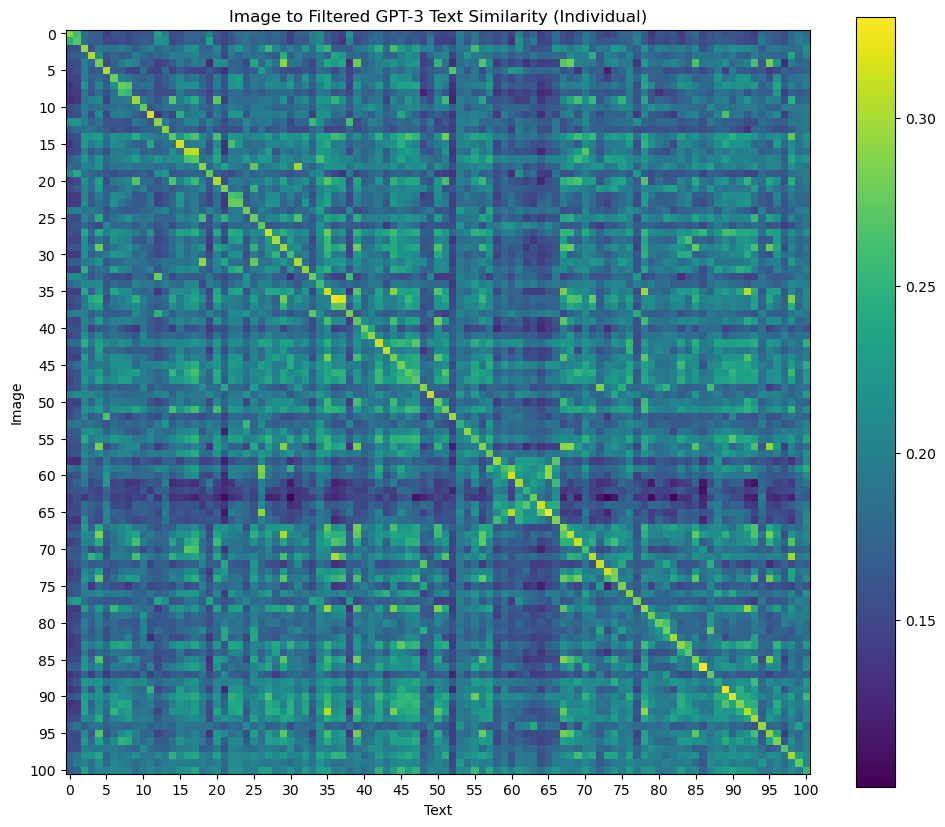

In [24]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image Similarity')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, 'Image to Class Name Similarity')
visualize_cross_similarity(img_template_cls_similarity, 'Image to Text Template Similarity')
visualize_cross_similarity(img_template_text_similarity, 'Image to Text Template Similarity (Individual)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, 'Image to Original GPT-3 Text Similarity')
visualize_cross_similarity(img_original_gpt3_text_similarity, 'Image to Original GPT-3 Text Similarity (Individual)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, 'Image to Filtered GPT-3 Text Similarity')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, 'Image to Filtered GPT-3 Text Similarity (Individual)')

In [25]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [26]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [27]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.94970703125
Rank 2: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.9306640625
Rank 3: (45)Juggling_Balls - (83)Soccer_Juggling, Similarity: 0.9296875
Rank 4: (39)High_Jump - (50)Long_Jump, Similarity: 0.92822265625
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.92041015625
Rank 6: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.916015625
Rank 7: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.91259765625
Rank 8: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.9072265625
Rank 9: (0)Apply_Eye_Makeup - (1)Apply_Lipstick, Similarity: 0.90673828125
Rank 10: (15)Bowling - (22)Cricket_Bowling, Similarity: 0.90283203125


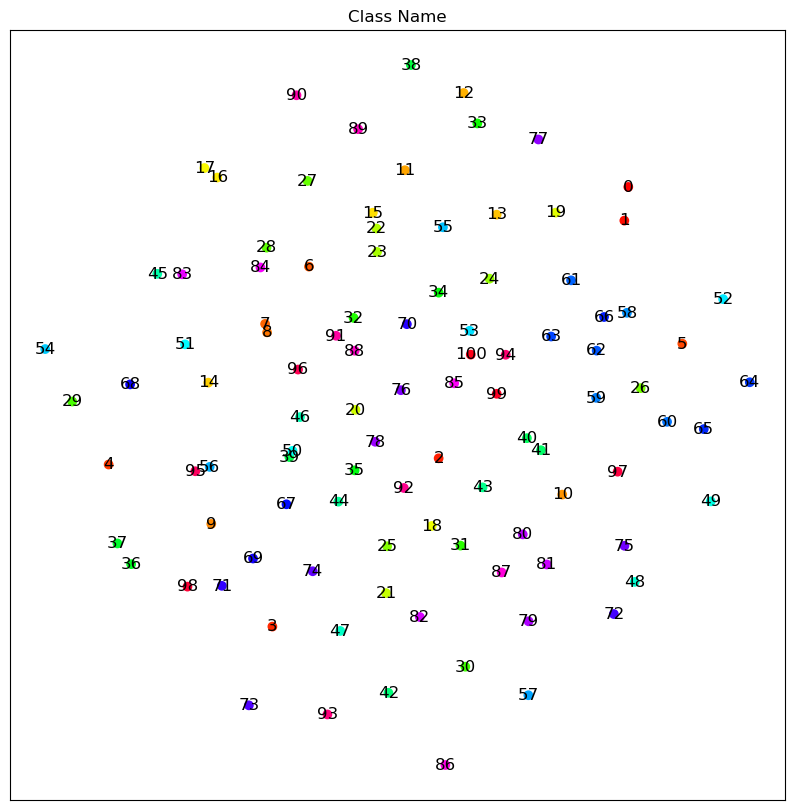

Rank 1: (39)High_Jump - (50)Long_Jump, Similarity: 0.95068359375
Rank 2: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.9501953125
Rank 3: (15)Bowling - (22)Cricket_Bowling, Similarity: 0.93408203125
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.9267578125
Rank 5: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.92431640625
Rank 6: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.92431640625
Rank 7: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.92138671875
Rank 8: (45)Juggling_Balls - (83)Soccer_Juggling, Similarity: 0.91552734375
Rank 9: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.90625
Rank 10: (58)Playing_Cello - (66)Playing_Violin, Similarity: 0.89892578125


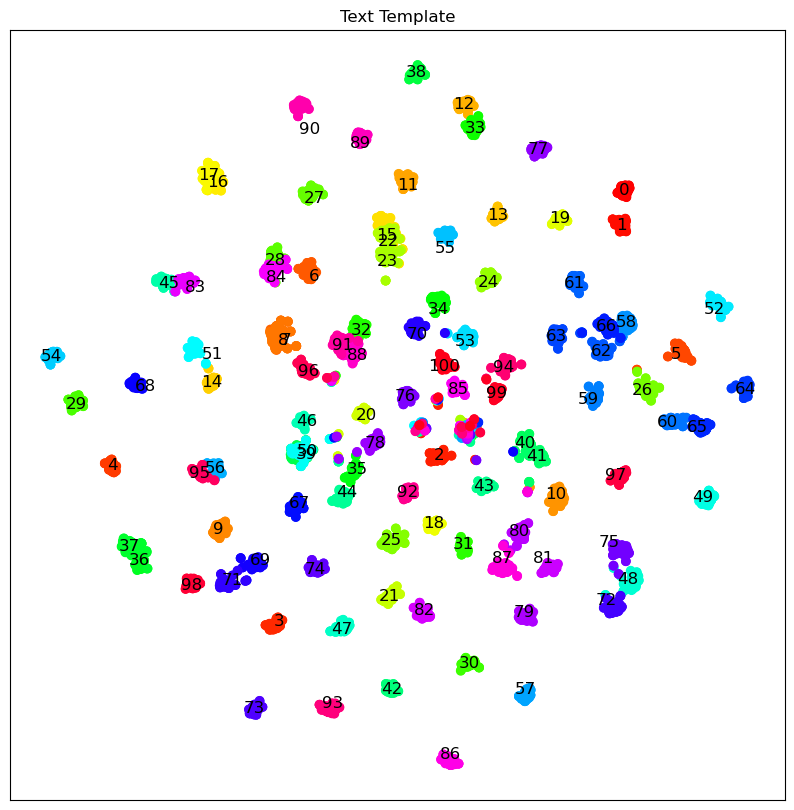

Rank 1: (18)Breast_Stroke - (31)Front_Crawl, Similarity: 0.96142578125
Rank 2: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.95361328125
Rank 3: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.951171875
Rank 4: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.9501953125
Rank 5: (39)High_Jump - (50)Long_Jump, Similarity: 0.9443359375
Rank 6: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.9404296875
Rank 7: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, Similarity: 0.931640625
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.93017578125
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, Similarity: 0.9208984375


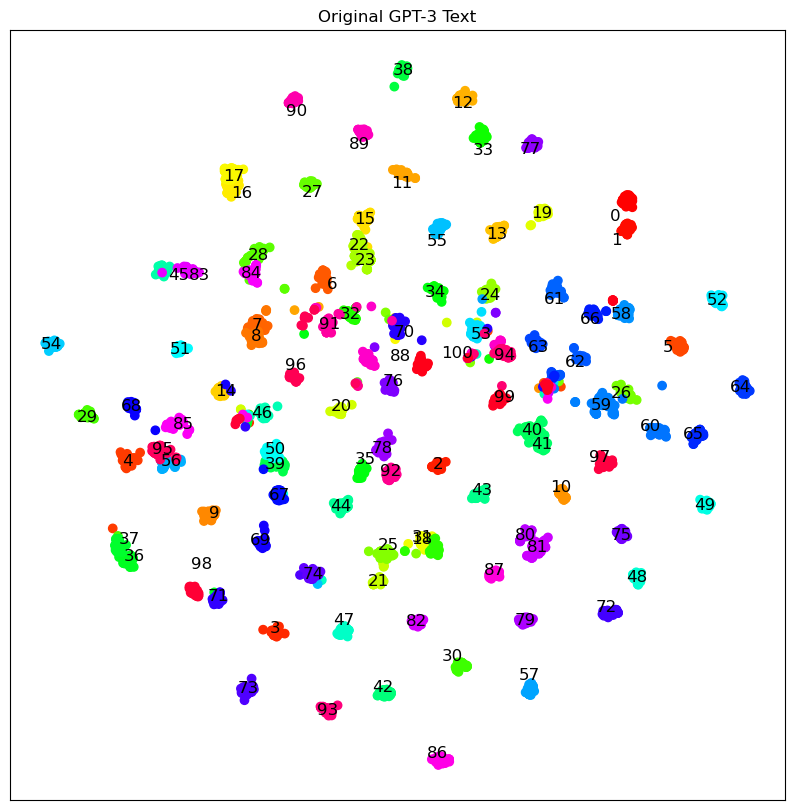

Rank 1: (18)Breast_Stroke - (31)Front_Crawl, Similarity: 0.95947265625
Rank 2: (7)Basketball - (8)Basketball_Dunk, Similarity: 0.95361328125
Rank 3: (36)Handstand_Pushups - (37)Handstand_Walking, Similarity: 0.94970703125
Rank 4: (16)Boxing_Punching_Bag - (17)Boxing_Speed_Bag, Similarity: 0.94970703125
Rank 5: (22)Cricket_Bowling - (23)Cricket_Shot, Similarity: 0.9404296875
Rank 6: (39)High_Jump - (50)Long_Jump, Similarity: 0.939453125
Rank 7: (40)Horse_Race - (41)Horse_Riding, Similarity: 0.93798828125
Rank 8: (56)Parallel_Bars - (95)Uneven_Bars, Similarity: 0.93017578125
Rank 9: (28)Field_Hockey_Penalty - (84)Soccer_Penalty, Similarity: 0.92431640625
Rank 10: (32)Golf_Swing - (91)Tennis_Swing, Similarity: 0.919921875


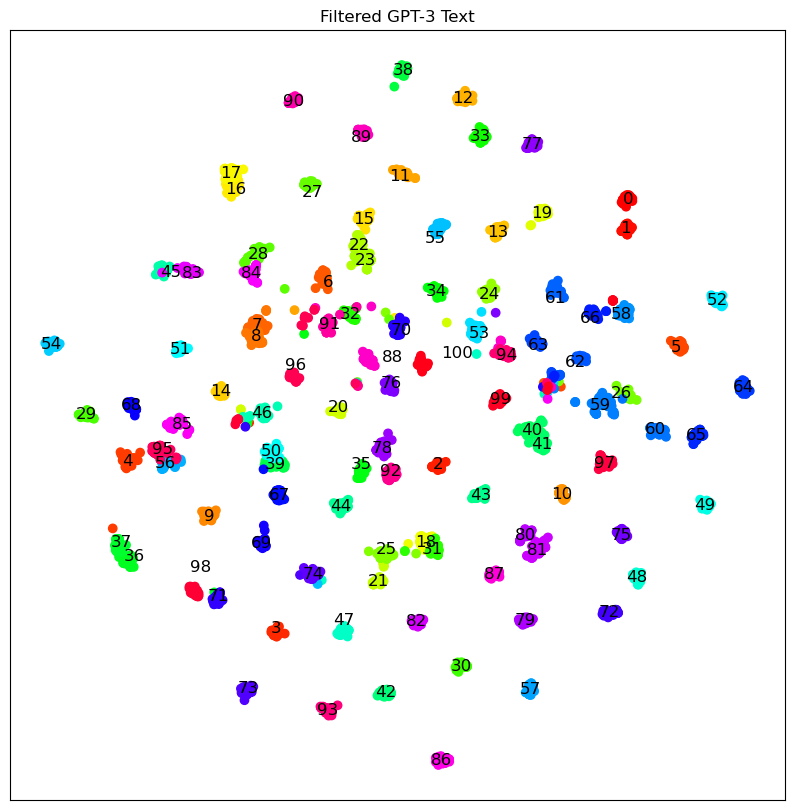

In [28]:
print_top_similarity(np.triu(cls_name_masked_similarity, k=1))
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_similarity(np.triu(template_masked_similarity, k=1))
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_similarity(np.triu(original_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_similarity(np.triu(filtered_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')